In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [14]:
from tensorflow import keras

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
y_train_d = np.array(train_df.loc[:,'label'])
X_train_d = np.array(train_df.loc[:,train_df.columns!='label'])
X_train_d.shape

(42000, 784)

In [5]:
X_test = np.array(test_df.loc[:,test_df.columns!='label'])
X_test.shape

(28000, 784)

In [6]:
X_train_d = X_train_d.astype('float32')
X_train_d = X_train_d / 255.0

In [7]:
X_test = X_test.astype('float32')
X_test = X_test / 255.0

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

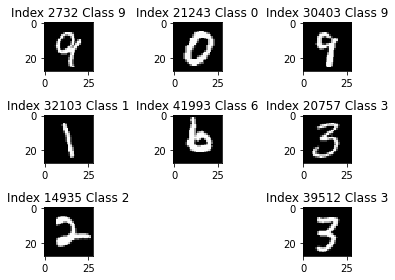

In [9]:
np.random.seed(0);
indices = list(np.random.randint(42000,size=9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train_d[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train_d[indices[i]]))
    plt.tight_layout()

In [10]:
class TwolayerNeuralNetwork(object):
    
    def __init__(self, input_size, hidden_size, output_size): 
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size)   
        self.params['b1'] = np.zeros((1, hidden_size))    
        self.params['W2'] = np.random.randn(hidden_size, output_size)   
        self.params['b2'] = np.zeros((1, output_size))
        
    def loss(self, X, y=None, reg=0.0):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape
        
        scores = None
        h1 = ReLU(np.dot(X, W1) + b1)      
        out = np.dot(h1, W2) + b2          
        scores = out
        if y is None:   
            return scores
        
        scores_max = np.max(scores, axis=1, keepdims=True)
        exp_scores = np.exp(scores - scores_max)              
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)   
        correct_logprobs = -np.log(probs[range(N), y])        
        data_loss = np.sum(correct_logprobs) / N
        reg_loss = 0.5 * reg * np.sum(W1*W1) + 0.5 * reg * np.sum(W2*W2)
        loss = data_loss + reg_loss
        
        grads = {}
        dscores = probs                                 
        dscores[range(N), y] -= 1
        dscores /= N
        
        dW2 = np.dot(h1.T, dscores)                  
        db2 = np.sum(dscores, axis=0, keepdims=True)
        dh1 = np.dot(dscores, W2.T)                     
        dh1[h1 <= 0] = 0
        dW1 = np.dot(X.T, dh1)                          
        db1 = np.sum(dh1, axis=0, keepdims=True)
        dW2 += reg * W2
        dW1 += reg * W1
        
        grads['W1'] = dW1
        grads['b1'] = db1
        grads['W2'] = dW2
        grads['b2'] = db2

        return loss, grads
    
    def train(self, X, y, learning_rate=1e-3, 
                reg=1e-5, num_epochs=10, 
                batch_size=200, verbose=False): 
        
        num_train = X.shape[0]
        iterations_per_epoch = max(int(num_train / batch_size), 1)
        
        beta =0.99
        v_dW2, v_db2 = 0.0, 0.0
        v_dW1, v_db1 = 0.0, 0.0
        loss_history = []
        train_acc_history = []
        
        for it in range(1, num_epochs * iterations_per_epoch + 1):   
            X_batch = None   
            y_batch = None 
            
            sample_index = np.random.choice(num_train, batch_size, replace=True)   
            X_batch = X[sample_index, :]          
            y_batch = y[sample_index]             
            
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg) 
            loss_history.append(loss)
    
            v_dW2 = beta * v_dW2 + (1 - beta) * grads['W2']
            v_db2 = beta * v_db2 + (1 - beta) * grads['b2'] 
            self.params['W2'] -= learning_rate * v_dW2
            self.params['b2'] -= learning_rate * v_db2
            v_dW1 = beta * v_dW1 + (1 - beta) * grads['W1']
            v_db1 = beta * v_db1 + (1 - beta) * grads['b1'] 
            self.params['W1'] -= learning_rate * v_dW1
            self.params['b1'] -= learning_rate * v_db1
            
            if verbose and it % iterations_per_epoch == 0:    
                epoch = it / iterations_per_epoch    
                train_acc = (self.predict(X_batch) == y_batch).mean()    
                train_acc_history.append(train_acc)    
                print("epoch %d / %d: loss %f, train_acc: %f" % 
                                    (epoch, num_epochs, loss, train_acc))
                if train_acc > 0.985:
                    break
                

        return {   
            'loss_history': loss_history,   
            'train_acc_history': train_acc_history,   
        }
    
    def predict(self, X):    

        y_pred = None    
        h1 = ReLU(np.dot(X, self.params['W1']) + self.params['b1'])    
        scores = np.dot(h1, self.params['W2']) + self.params['b2']    
        y_pred = np.argmax(scores, axis=1)    

        return y_pred
    
def ReLU(x):    
    return np.maximum(0, x)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_d,y_train_d, test_size=0.25, random_state=42)

In [12]:
input_size = X_train.shape[1]
hidden_size = 64
num_classes = 10
net = TwolayerNeuralNetwork(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train,
            num_epochs=25, batch_size=32,
            learning_rate= 9*1e-3, 
            reg=1e-3, verbose=True)

# Predict on the test set
test_acc = (net.predict(X_test) == y_test).mean()
print("Test Accuracy", test_acc)

epoch 1 / 25: loss 29.076970, train_acc: 0.750000
epoch 2 / 25: loss 28.502713, train_acc: 0.656250
epoch 3 / 25: loss 25.541739, train_acc: 0.781250
epoch 4 / 25: loss 24.477484, train_acc: 0.781250
epoch 5 / 25: loss 23.875355, train_acc: 0.875000
epoch 6 / 25: loss 24.082447, train_acc: 0.781250
epoch 7 / 25: loss 23.307834, train_acc: 0.843750
epoch 8 / 25: loss 22.306997, train_acc: 0.906250
epoch 9 / 25: loss 21.975072, train_acc: 0.843750
epoch 10 / 25: loss 21.990678, train_acc: 0.718750
epoch 11 / 25: loss 21.586302, train_acc: 0.843750
epoch 12 / 25: loss 21.069077, train_acc: 0.906250
epoch 13 / 25: loss 20.385464, train_acc: 0.875000
epoch 14 / 25: loss 20.183011, train_acc: 0.843750
epoch 15 / 25: loss 20.101558, train_acc: 0.750000
epoch 16 / 25: loss 19.294050, train_acc: 0.937500
epoch 17 / 25: loss 19.964323, train_acc: 0.843750
epoch 18 / 25: loss 18.617817, train_acc: 0.906250
epoch 19 / 25: loss 18.218457, train_acc: 0.937500
epoch 20 / 25: loss 18.283968, train_acc

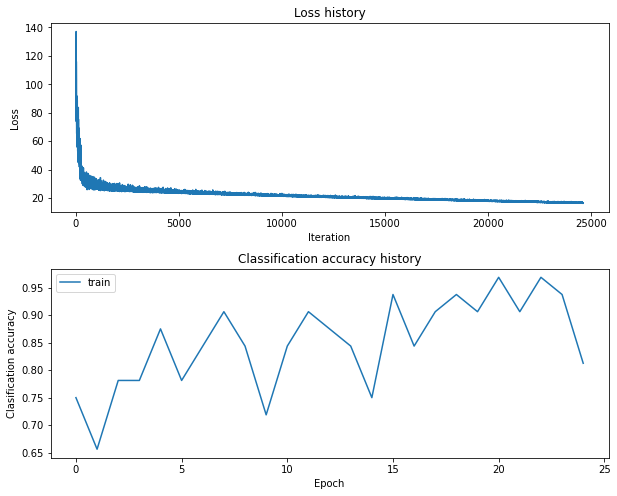

In [13]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.subplots_adjust(wspace =0, hspace =0.3)


# Plot the loss function and train accuracy

plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()